# Comparing new momentum distributions code to old LDA code

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ February 15, 2023

This notebook compares the old LDA momentum distributions code to the new code which uses single-particle wave functions and `vegas` to integrate over momenta. There are differences in how each calculation is implemented, but the SRG transformations are unitary; therefore, the normalization of the momentum distribution should give $Z$ (or $N$).

_Last update:_ February 28, 2023

In [1]:
# Python imports
import functools
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator
import time
import vegas

In [2]:
# Imports from scripts
from scripts.figures import label_ticks, set_rc_parameters
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix
)
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import channel_L_value, coupled_channel, find_index

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Compare the $|\mathbf{q}-\frac{\mathbf{K}}{2}|$ dependence

In [4]:
def f1(q_array, K_array, K_weights, x_array, x_weights):
    """Computes 4\pi \int_0^\infty dK K^2 \int_{-1}^1 dx/2 |q-K\2|."""
    
    q_grid, K_grid, x_grid = np.meshgrid(q_array, K_array, x_array,
                                         indexing='ij')
    
    _, dK_grid, dx_grid = np.meshgrid(q_array, K_weights, x_weights,
                                      indexing='ij')
    
    qK_norm_grid = np.sqrt(q_grid**2 + K_grid**2/4 - q_grid * K_grid * x_grid)
    
    integrand_K_x = qK_norm_grid * K_grid**2 * dK_grid * dx_grid/2
    
    # integrate over x
    integrand_K = np.sum(integrand_K_x, axis=-1)
    
    # integrate over K
    return 4*np.pi*np.sum(integrand_K, axis=-1)

In [5]:
def f2_integrand(q, momenta_array):
    """Integrand of f_2(q)."""
    
    # Choose z-axis to be along q_vector
    q_vector = np.array([0, 0, q])

    # C.o.M. momenta K
    K, theta, phi = momenta_array
    K_vector = np.array([K * np.sin(theta) * np.cos(phi),
                         K * np.sin(theta) * np.sin(phi),
                         K * np.cos(theta)])
    
    # Calculate vector q-K/2
    qK_vector = q_vector - K_vector/2
    qK = la.norm(qK_vector)
        
    # Calculate the Jacobian determinant
    jacobian = K**2 * np.sin(theta)
    
    return qK * jacobian

In [6]:
def f2(q_array):
    """Computes \int_0^\infty dK K^2 \int_0^\pi sin(\theta) d\theta
    \int_0^{2\pi} d\phi |q-K\2|, where the z-axis is along q_vector using vegas.
    """

    # Set-up integration with vegas
    K_limits = [0, 2.7]  # C.o.M. momenta up to 3 fm^-1
    theta_limits = [0, np.pi]
    phi_limits = [0, 2*np.pi]

    # Set-up integrator with multiple processors
    integ = vegas.Integrator([K_limits, theta_limits, phi_limits])

    # Loop over q_vector
    func_q_array = np.zeros_like(q_array)
    t0 = time.time()
    for iq, q in enumerate(q_array):
        
        integrand = functools.partial(f2_integrand, q)
        
        # Train the integrator
        integ(integrand, nitn=5, neval=1e3)
        # Final result
        result = integ(integrand, nitn=10, neval=3e3)

        func_q_array[iq] = result.mean

    t1 = time.time()
    mins = (t1-t0)/60
    print(f"Done after {mins:.3f} minutes.")
                    
    return func_q_array

In [7]:
def f3(q_array, K_array, K_weights):
    """Computes \int_0^\infty dK K^2 \int_0^\pi sin(\theta) d\theta 
    \int_0^{2\pi} d\phi |q-K\2|, where the z-axis is along q_vector using
    Gaussian quadrature.
    """
    
    theta_array, theta_weights = gaussian_quadrature_mesh(np.pi, 9)
    phi_array, phi_weights = gaussian_quadrature_mesh(2*np.pi, 17)
    
    func_q_array = np.zeros_like(q_array)
    for iq, q in enumerate(q_array):
        
        q_vector = np.array([0, 0, q])
        
        value = 0
        for iK, K in enumerate(K_array):
            for it, t in enumerate(theta_array):
                for ip, p in enumerate(phi_array):
                    
                    K_vector = np.array([K*np.sin(t)*np.cos(p),
                                         K*np.sin(t)*np.sin(p),
                                         K*np.cos(t)])
                    
                    qK_norm = la.norm(q_vector - K_vector/2)
                    dK = K_weights[iK]
                    dt = theta_weights[it]
                    dp = phi_weights[ip]
                    
                    value += qK_norm * K**2 * dK * np.sin(t) * dt * dp
                    
        func_q_array[iq] = value
        
    return func_q_array

In [8]:
# x_array, x_weights = leggauss(7)  # Angles between q and K for angle-averaging
# K_array, K_weights = gaussian_quadrature_mesh(2.7, 40)
# q_array, _ = gaussian_quadrature_mesh(8.0, 40)

# f1_array = f1(q_array, K_array, K_weights, x_array, x_weights)
# f2_array = f2(q_array)
# f3_array = f3(q_array, K_array, K_weights)

# plt.plot(q_array, f1_array, label=r'$f_1(q)$', linestyle='-')
# plt.plot(q_array, f2_array, label=r'$f_2(q)$', linestyle='--')
# plt.plot(q_array, f3_array, label=r'$f_3(q)$', linestyle=':')
# plt.ylim((0.0, 700.0))
# plt.xlabel(r'q [fm$^{-1}$]')
# plt.ylabel(r'f(q) [fm$^{-4}$]')
# plt.legend(loc='upper left')
# plt.show()

Showing the difference between angle-averaging compared to integrating over all angles of $\mathbf{K}$ (using `vegas` and Gaussian quadrature) to evaluate the vector norm $|\mathbf{q}-\frac{\mathbf{K}}{2}|$.

$$
f_1(q) = 4\pi \int_0^\infty dK K^2 \int_{-1}^{1} \frac{dx}{2}\, |\mathbf{q}-\frac{\mathbf{K}}{2}|,
$$
where $|\mathbf{q}-\frac{\mathbf{K}}{2}| = \sqrt{q^2+K^2/4-qKx}$.<br>

$$
f_{2,3}(q) = \int_0^\infty dK K^2 \int_0^\pi \sin(\theta) d\theta \int_0^{2\pi} d\phi\,
    |\mathbf{q}-\frac{\mathbf{K}}{2}|,
$$
where $\mathbf{q}=\langle 0,0,q \rangle$ and $\mathbf{K}=\langle K \sin(\theta) \cos(\phi), K \sin(\theta) \sin(\phi), K \cos(\theta) \rangle$.<br>

$f_2(q)$ is evaluated using `vegas` and $f_3(q)$ is evaluated using Gaussian quadrature.

## Compare interpolation of $\delta U$ between codes

### Common arguments

In [9]:
kvnn, kmax, kmid, ntot = 6, 15.0, 3.0, 120
# kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
# kvnn, kmax, kmid, ntot = 113, 15.0, 3.0, 120
channel = '3S1'
# channel = '3P1'
generator = 'Wegner'
lamb = 1.35

# Set potential
potential = Potential(kvnn, channel, kmax, kmid, ntot)

### Functions from `momentum_distributions.py` (old LDA code)

In [10]:
def get_deltaU_matrix_element(channel, delta_U_matrix, ntot):
    
    # This case corresponds to coupled-channel partial waves
    if coupled_channel(channel):

        # First L of coupled-channel
        deltaU = delta_U_matrix[:ntot, :ntot]
        deltaU_squared = (delta_U_matrix[:ntot, :ntot] ** 2
                          + delta_U_matrix[:ntot, ntot:] ** 2)

    else:

        deltaU = delta_U_matrix
        deltaU_squared = delta_U_matrix ** 2
        
    return deltaU, deltaU_squared

In [11]:
def interpolated_delta_U_lda(potential, channel, order=3):
    """
    Function that returns interpolated \delta U(k,k'), \delta U^\dagger(k,k'),
    and \delta U (k, k') \delta U^\dagger(k', k).
    """
    
    # Get momentum mesh
    k_array, k_weights = potential.load_mesh()
    ntot = potential.ntot

    # Initial Hamiltonian
    H_initial = potential.load_hamiltonian()
    # Evolved Hamiltonian
    H_evolved = potential.load_hamiltonian('srg', generator, lamb)

    # Get SRG transformation U(k, k') [unitless]
    U_matrix_unitless = get_transformation(H_initial, H_evolved)
    # Coupled-channel?
    cc_bool = coupled_channel(channel)

    # Isolate 2-body term and convert to fm^3
    if cc_bool:
        I_matrix_unitless = np.eye(2 * ntot, 2 * ntot)
    else:
        I_matrix_unitless = np.eye(ntot, ntot)
    delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
        
    delta_U_matrix = unattach_weights_from_matrix(
        k_array, k_weights, delta_U_matrix_unitless, cc_bool
    )  # fm^3

    deltaU, deltaU2 = get_deltaU_matrix_element(channel, delta_U_matrix, ntot)

    # Interpolate \delta U(k,k')
    deltaU_func = RectBivariateSpline(k_array, k_array, deltaU, kx=order,
                                      ky=order)
    deltaU_dag_func = RectBivariateSpline(k_array, k_array, deltaU.T, kx=order,
                                          ky=order)
    deltaU2_func = RectBivariateSpline(k_array, k_array, deltaU2, kx=order,
                                       ky=order)
        
    return deltaU_func, deltaU_dag_func, deltaU2_func

### Functions from `test_momentum_distribution_script.py`

In [12]:
def interpolate_delta_U(
        potential, channel, hermitian_conjugate=False, squared=False,
        order=3
):
    """Function that returns interpolated \delta U(k, k'),
    \delta U^\dagger(k, k') or \delta U^2(k, k') given the partial wave channel.
    """
    
    # Get momentum mesh
    k_array, k_weights = potential.load_mesh()
    ntot = potential.ntot

    # Initial Hamiltonian
    H_initial = potential.load_hamiltonian()
    # Evolved Hamiltonian
    H_evolved = potential.load_hamiltonian('srg', generator, lamb)
    
    # Get SRG transformation from Hamiltonians
    U_matrix_weights = get_transformation(H_initial, H_evolved)
    
    # Calculate \delta U = U - I
    I_matrix_weights = np.eye(len(H_initial), len(H_initial))
    if hermitian_conjugate:
        delU_matrix_weights = (U_matrix_weights - I_matrix_weights).T
    else:
        delU_matrix_weights = U_matrix_weights - I_matrix_weights

    # Get specific sub-block if coupled-channel
    if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[:ntot,ntot:])
    elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[ntot:,:ntot])
    elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[ntot:,ntot:])
    else:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[:ntot,:ntot])
        
    # Interpolate \delta U^2(k, k') = \delta U(k, k') \delta U^\dagger(k', k)
    if squared:
        delU_func = RectBivariateSpline(k_array, k_array, delU_matrix**2,
                                        kx=order, ky=order)
    # Interpolate \delta U(k, k') or \delta U^\dagger(k, k')
    else:
        delU_func = RectBivariateSpline(k_array, k_array, delU_matrix, kx=order,
                                        ky=order)
    
    return delU_func

In [13]:
def get_delta_U_functions(potential, channel, order=3):
    
    if channel == '3S1':
        channels = ('3S1-3S1', '3S1-3D1', '3D1-3S1')
    else:
        channels = [channel]

    delta_U_functions = {}
    delta_U_dagger_functions = {}
    delta_U2_functions = {}
    for ichannel in channels:
        delta_U_functions[ichannel] = interpolate_delta_U(potential, ichannel,
                                                          order=order)
        delta_U_dagger_functions[ichannel] = interpolate_delta_U(
            potential, ichannel, hermitian_conjugate=True, order=order
        )
        delta_U2_functions[ichannel] = interpolate_delta_U(
            potential, ichannel, squared=True, order=order
        )

    return delta_U_functions, delta_U_dagger_functions, delta_U2_functions

### Comparison

In [14]:
# # Compare the interpolated functions evaluating at random (k, k') points
# k, kp = 1.0, 2.0
# # k, kp, = 0.5, 7.5
# # k, kp, = 5, 7.5

In [15]:
# # LDA
# deltaU_func_lda, deltaU_dag_func_lda, deltaU2_func_lda = (
#     interpolated_delta_U_lda(potential, channel, order=3)
# )

# deltaU_lda = deltaU_func_lda.ev(k, kp)
# deltaU_dag_lda = deltaU_dag_func_lda.ev(k, kp)
# deltaU2_lda = deltaU2_func_lda.ev(k, kp)

# print("LDA result:\n")
# print(f"\delta U(k, k') = {deltaU_lda}.")
# print(f"\delta U^\dagger(k, k') = {deltaU_dag_lda}.")
# print(f"\delta U(k, k') \delta U^\dagger(k', k) = {deltaU2_lda}.\n")

In [16]:
# # New code
# delta_U_functions, delta_U_dagger_functions, delta_U2_functions = (
#     get_delta_U_functions(potential, channel, order=3)
# )

# if channel == '3S1':
    
#     deltaU = delta_U_functions['3S1-3S1'].ev(k, kp)
#     deltaU_dag = delta_U_dagger_functions['3S1-3S1'].ev(k, kp)
    
#     # Individually interpolated \delta U and \delta U^\dagger
#     deltaU2 = (
#         delta_U_functions['3S1-3S1'].ev(k, kp)
#         * delta_U_dagger_functions['3S1-3S1'].ev(kp, k)
#         + delta_U_functions['3S1-3D1'].ev(k, kp)
#         * delta_U_dagger_functions['3D1-3S1'].ev(kp, k)
#     )

# #     # Interpolated \delta U^2
# #     deltaU2 = (
# #         delta_U2_functions['3S1-3S1'].ev(k, kp)
# #         + delta_U2_functions['3S1-3D1'].ev(k, kp)
# #     )
    
# else:
    
#     deltaU = delta_U_functions[channel].ev(k, kp)
#     deltaU_dag = delta_U_dagger_functions[channel].ev(k, kp)
#     deltaU2 = (
#         delta_U_functions[channel].ev(k, kp)
#         * delta_U_dagger_functions[channel].ev(kp, k)
#     )

# print("New code result:\n")
# print(f"\delta U(k, k') = {deltaU}.")
# print(f"\delta U^\dagger(k, k') = {deltaU_dag}.")
# print(f"\delta U(k, k') \delta U^\dagger(k', k) = {deltaU2}.\n")

In [17]:
# print(f"Difference in \delta U(k, k') = {abs(deltaU_lda-deltaU)}.")
# print(
#     f"Difference in \delta U^\dagger(k, k') = {abs(deltaU_dag_lda-deltaU_dag)}."
# )
# print(
#     "Difference in \delta U(k, k') \delta U^\dagger(k', k) ="
#     f" {abs(deltaU2_lda-deltaU2)}."
# )

In [18]:
# # 3S1-3D1 sanity check
# print(delta_U_functions['3D1-3S1'].ev(k, kp))
# print(delta_U_dagger_functions['3S1-3D1'].ev(kp, k))
# product = (delta_U_functions['3S1-3D1'].ev(k, kp)
#            * delta_U_dagger_functions['3D1-3S1'].ev(kp, k))
# print(product)
# print(delta_U_functions['3S1-3D1'].ev(k, kp) ** 2)
# print(delta_U_functions['3S1-3D1'].ev(k, kp) ** 2 - product)

In [19]:
# # 3S1-3S1 sanity check
# print(delta_U_dagger_functions['3S1-3S1'].ev(kp, k))
# print(delta_U_functions['3S1-3S1'].ev(k, kp))
# product = (delta_U_functions['3S1-3S1'].ev(k, kp)
#            * delta_U_dagger_functions['3S1-3S1'].ev(kp, k))
# print(product)
# print(delta_U_functions['3S1-3S1'].ev(k, kp) ** 2)
# print(delta_U_functions['3S1-3S1'].ev(k, kp) ** 2 - product)

## Compare interpolation options from `scipy.interpolate`

### Set-up

In [20]:
# Get momentum mesh
ntot = 120
k_array, k_weights = momentum_mesh(15.0, 3.0, ntot)

# Get momentum meshgrid
k_fine_array = np.linspace(k_array[0], k_array[-1], 500)
k_grid, kp_grid = np.meshgrid(k_fine_array, k_fine_array, indexing='ij')

# Initial Hamiltonian
H_initial = potential.load_hamiltonian()
# Evolved Hamiltonian
H_evolved = potential.load_hamiltonian('srg', generator, lamb)
    
# Get SRG transformation from Hamiltonians
U_matrix_weights = get_transformation(H_initial, H_evolved)
    
# Calculate \delta U = U - I
I_matrix_weights = np.eye(len(H_initial), len(H_initial))
delU_matrix_weights = U_matrix_weights - I_matrix_weights

# Full 3S1-3D1 coupled-channel matrix in units fm^3 (no integration factors)
delU_matrix = unattach_weights_from_matrix(
    k_array, k_weights, delU_matrix_weights, coupled_channel=True)

In [21]:
# Get interpolating functions
# Linear
(delta_U_linear_functions, delta_U_dag_linear_functions,
 delta_U2_linear_functions) = get_delta_U_functions(potential, channel, order=1)

# Cubic
(delta_U_cubic_functions, delta_U_dag_cubic_functions,
 delta_U2_cubic_functions) = get_delta_U_functions(potential, channel, order=3)

# Quintic
(delta_U_quintic_functions, delta_U_dag_quintic_functions,
 delta_U2_quintic_functions) = get_delta_U_functions(potential, channel,
                                                     order=5)

In [22]:
# Evaluate interpolating functions on meshgrid for 3S1-3S1 channel
# Linear
deltaU_3S1_3S1_linear_grid = delta_U_linear_functions['3S1-3S1'].ev(k_grid,
                                                                    kp_grid)
# Cubic
deltaU_3S1_3S1_cubic_grid = delta_U_cubic_functions['3S1-3S1'].ev(k_grid,
                                                                  kp_grid)
# Quintic
deltaU_3S1_3S1_quintic_grid = delta_U_quintic_functions['3S1-3S1'].ev(k_grid,
                                                                      kp_grid)

# RegularGridInterpolator
deltaU_reggrid_3S1_3S1_func = RegularGridInterpolator(
    (k_array, k_array), delU_matrix[:ntot,:ntot], method='nearest'
)
deltaU_3S1_3S1_reggrid = deltaU_reggrid_3S1_3S1_func((k_grid, kp_grid))

In [23]:
# Evaluate interpolating functions on meshgrid for 3S1-3D1 channel
# Linear
deltaU_3S1_3D1_linear_grid = delta_U_linear_functions['3S1-3D1'].ev(k_grid,
                                                                    kp_grid)
# Cubic
deltaU_3S1_3D1_cubic_grid = delta_U_cubic_functions['3S1-3D1'].ev(k_grid,
                                                                  kp_grid)
# Quintic
deltaU_3S1_3D1_quintic_grid = delta_U_quintic_functions['3S1-3D1'].ev(k_grid,
                                                                      kp_grid)

# RegularGridInterpolator
deltaU_reggrid_3S1_3D1_func = RegularGridInterpolator(
    (k_array, k_array), delU_matrix[:ntot, ntot:], method='nearest'
)
deltaU_3S1_3D1_reggrid = deltaU_reggrid_3S1_3D1_func((k_grid, kp_grid))

In [24]:
# # Check that looping over k_fine_array twice gives the same grid:
# deltaU_3S1_3D1_test = np.zeros_like(deltaU_3S1_3D1_reggrid)
# for i, ik in enumerate(k_fine_array):
#     for j, jk in enumerate(k_fine_array):
#         deltaU_3S1_3D1_test[i, j] = deltaU_reggrid_func((ik, jk))
# print(deltaU_3S1_3D1_test-deltaU_3S1_3D1_reggrid)
# # THIS WORKS

In [25]:
# Matrix elements of \delta U^2(k, k')
delU2_matrix = delU_matrix[:ntot, :ntot]**2 + delU_matrix[:ntot, ntot:]**2

# Linear
deltaU2_linear_grid = (
    delta_U2_linear_functions['3S1-3S1'].ev(k_grid, kp_grid)
    + delta_U2_linear_functions['3S1-3D1'].ev(k_grid, kp_grid)
)
# Cubic
deltaU2_cubic_grid = (
    delta_U2_cubic_functions['3S1-3S1'].ev(k_grid, kp_grid)
    + delta_U2_cubic_functions['3S1-3D1'].ev(k_grid, kp_grid)
)
# Quintic
deltaU2_quintic_grid = (
    delta_U2_quintic_functions['3S1-3S1'].ev(k_grid, kp_grid)
    + delta_U2_quintic_functions['3S1-3D1'].ev(k_grid, kp_grid)
)
# RegularGridInterpolator
deltaU2_reggrid = (
    deltaU_reggrid_3S1_3S1_func((k_grid, kp_grid))**2
    + deltaU_reggrid_3S1_3D1_func((k_grid, kp_grid))**2
)

In [26]:
# TESTING C-CONTIGUOUS THING
deltaU_reggrid_3S1_3S1_func((0.5, 0.3))
# This same code does not work in Spyder, PyCharm, or running a script from the
# terminal (e.g. "python test_momentum_distribution_scipt.py")

array(-0.26130733)

### Plot matrix elements of $\delta U$

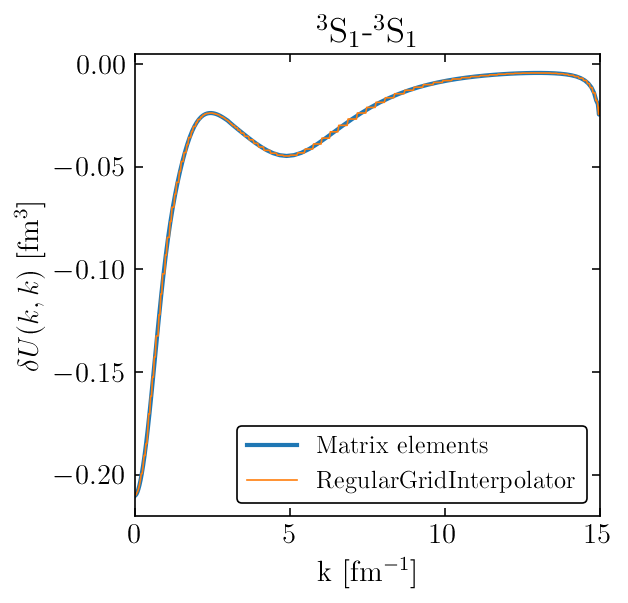

In [27]:
# Plot \delta U(k,k) in 3S1-3S1 channel
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))

ax.plot(k_array, np.diag(delU_matrix[:ntot, :ntot]), label='Matrix elements',
        linestyle='-', linewidth=2.0)
# ax.plot(k_fine_array, np.diag(deltaU_3S1_3S1_linear_grid),
#         label='Linear interpolation', linestyle='-', linewidth=0.8)
# ax.plot(k_fine_array, np.diag(deltaU_3S1_3S1_cubic_grid),
#         label='Cubic interpolation', linestyle='-', linewidth=0.8)
# ax.plot(k_fine_array, np.diag(deltaU_3S1_3S1_quintic_grid),
#         label='Quintic interpolation', linestyle='-', linewidth=0.8)
ax.plot(k_fine_array, np.diag(deltaU_3S1_3S1_reggrid),
        label='RegularGridInterpolator', linestyle='-', linewidth=0.8)

# Full figure
ax.set_xlim((0.0, 15.0))
ax.set_ylim((-0.22, 0.005))

ax.set_xlabel(r'k [fm$^{-1}$]')
ax.set_ylabel(r'$\delta U(k, k)$ [fm$^3$]')
ax.legend(fontsize=12, loc='lower right')
ax.set_title(r"$^{3}$S$_1$-$^{3}$S$_1$")
plt.show()

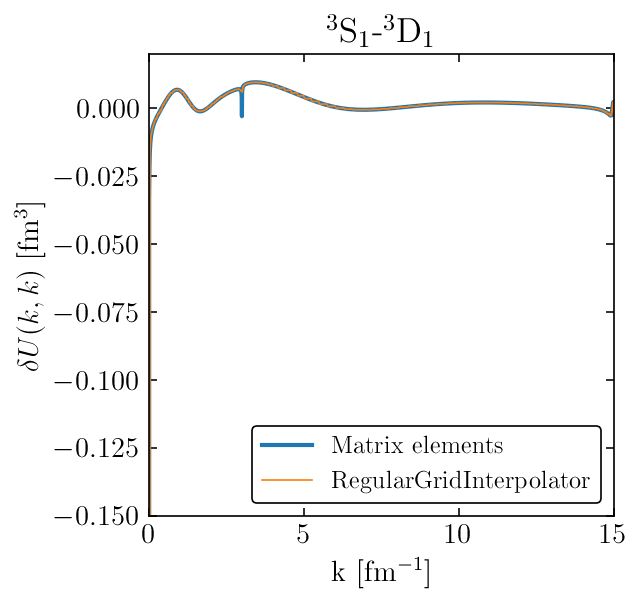

In [28]:
# Plot \delta U(k,k) in 3S1-3D1 channel
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))

ax.plot(k_array, np.diag(delU_matrix[:ntot,ntot:]), label='Matrix elements',
        linestyle='-', linewidth=2.0)
# ax.plot(k_fine_array, np.diag(deltaU_3S1_3D1_linear_grid),
#         label='Linear interpolation', linestyle='-', linewidth=0.8)
# ax.plot(k_fine_array, np.diag(deltaU_3S1_3D1_cubic_grid),
#         label='Cubic interpolation', linestyle='-', linewidth=0.8)
# ax.plot(k_fine_array, np.diag(deltaU_3S1_3D1_quintic_grid),
#         label='Quintic interpolation', linestyle='-', linewidth=0.8)
ax.plot(k_fine_array, np.diag(deltaU_3S1_3D1_reggrid),
        label='RegularGridInterpolator', linestyle='-', linewidth=0.8)

# Full figure
ax.set_xlim((0.0, 15.0))
ax.set_ylim((-0.15, 0.02))

# # Zoom-in on k~3 fm^-1 area
# ax.set_xlim((2.8, 4.5))
# ax.set_ylim((-0.15, 0.03))

# # Zoom-in on k -> 0 fm^-1 area
# ax.set_xlim((0.0, 0.01))
# ax.set_ylim((-200, 10))

ax.set_xlabel(r'k [fm$^{-1}$]')
ax.set_ylabel(r'$\delta U(k, k)$ [fm$^3$]')
ax.legend(fontsize=12, loc='lower right')
ax.set_title(r"$^{3}$S$_1$-$^{3}$D$_1$")
plt.show()

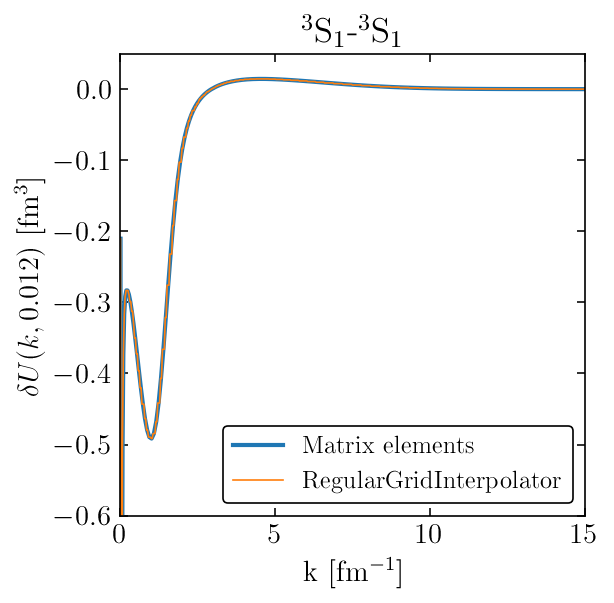

In [29]:
# Plot \delta U(k, k'=0.0012) in 3S1-3S1 channel
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))

ax.plot(k_array, delU_matrix[:ntot, 0], label='Matrix elements',
        linestyle='-', linewidth=2.0)
# ax.plot(k_fine_array, deltaU_3S1_3S1_linear_grid[:, 0],
#         label='Linear interpolation', linestyle='-', linewidth=0.8)
# ax.plot(k_fine_array, deltaU_3S1_3S1_cubic_grid[:, 0],
#         label='Cubic interpolation', linestyle='-', linewidth=0.8)
# ax.plot(k_fine_array, deltaU_3S1_3S1_quintic_grid[:, 0],
#         label='Quintic interpolation', linestyle='-', linewidth=0.8)
ax.plot(k_fine_array, deltaU_3S1_3S1_reggrid[:, 0],
        label='RegularGridInterpolator', linestyle='-', linewidth=0.8)

# Full figure
ax.set_xlim((0.0, 15.0))
ax.set_ylim((-0.6, 0.05))

# # Zoom-in on k -> 0 fm^-1 area
# ax.set_xlim((0.0, 1.0))
# ax.set_ylim((-0.6, 0.05))

ax.set_xlabel(r'$k$ [fm$^{-1}$]')
ax.set_ylabel(r'$\delta U(k, 0.012)$ [fm$^3$]')
ax.legend(fontsize=12, loc='lower right')
ax.set_title(r"$^{3}$S$_1$-$^{3}$S$_1$")
plt.show()

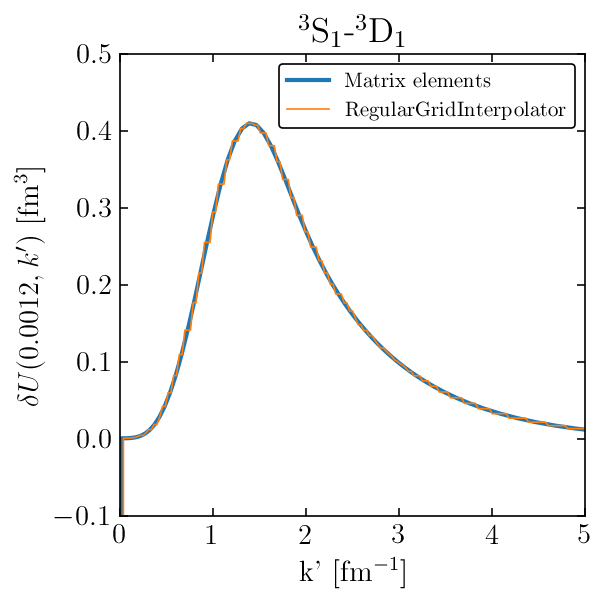

In [30]:
# Plot \delta U(k=0.0012, k') in 3S1-3D1 channel

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))

ax.plot(k_array, delU_matrix[0, ntot:], label='Matrix elements', linestyle='-',
        linewidth=2.0)
# ax.plot(k_fine_array, deltaU_3S1_3D1_linear_grid[0, :],
#         label='Linear interpolation', linestyle='-', linewidth=0.8)
# ax.plot(k_fine_array, deltaU_3S1_3D1_cubic_grid[0, :],
#         label='Cubic interpolation', linestyle='-', linewidth=0.8)
# ax.plot(k_fine_array, deltaU_3S1_3D1_quintic_grid[0, :],
#         label='Quintic interpolation', linestyle='-', linewidth=0.8)
ax.plot(k_fine_array, deltaU_3S1_3D1_reggrid[0, :],
        label='RegularGridInterpolator', linestyle='-', linewidth=0.8)

# Full figure
ax.set_xlim((0.0, 5.0))
ax.set_ylim((-0.1, 0.5))

ax.set_xlabel(r"$k'$ [fm$^{-1}$]")
ax.set_ylabel(r"$\delta U(0.0012, k')$ [fm$^3$]")
ax.legend(fontsize=10, loc='upper right')
ax.set_title(r"$^{3}$S$_1$-$^{3}$D$_1$")
plt.show()

### Plot matrix elements of $\delta U^2$

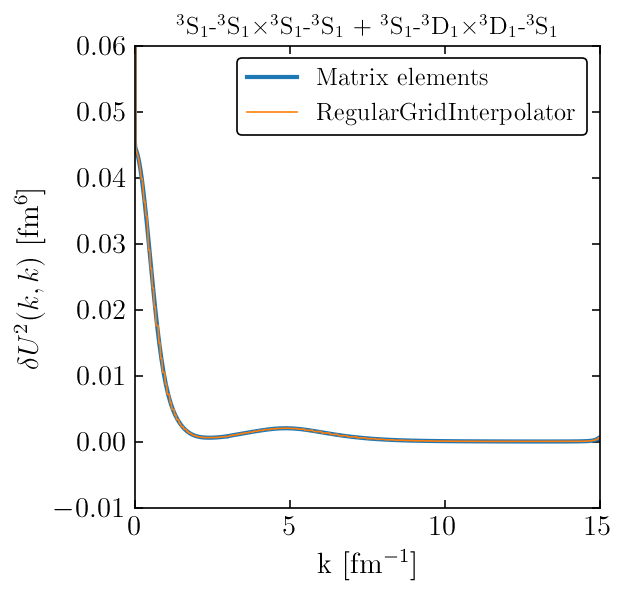

In [31]:
# Plot \delta U(k,k)
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))

ax.plot(k_array, np.diag(delU2_matrix), label='Matrix elements',
        linestyle='-', linewidth=2.0)
# ax.plot(k_fine_array, np.diag(deltaU2_linear_grid),
#         label='Linear interpolation', linestyle='-', linewidth=0.8)
# ax.plot(k_fine_array, np.diag(deltaU2_cubic_grid), label='Cubic interpolation',
#         linestyle='-', linewidth=0.8)
# ax.plot(k_fine_array, np.diag(deltaU2_quintic_grid),
#         label='Quintic interpolation', linestyle='-', linewidth=0.8)
ax.plot(k_fine_array, np.diag(deltaU2_reggrid), label='RegularGridInterpolator',
        linestyle='-', linewidth=0.8) 

# Full figure
ax.set_xlim((0.0, 15.0))
ax.set_ylim((-0.01, 0.06))

# # Zoom-in on tail
# ax.set_xlim((2.8, 7.0))
# ax.set_ylim((-0.001, 0.01))

# # Zoom-in at k -> 0
# ax.set_xlim((0.0, 0.01))
# ax.set_ylim((-300, 13000))

ax.set_xlabel(r'k [fm$^{-1}$]')
ax.set_ylabel(r'$\delta U^2(k, k)$ [fm$^6$]')
ax.legend(loc='upper right', fontsize=12)
ax.set_title(
    r"$^{3}$S$_1$-$^{3}$S$_1 \times ^{3}$S$_1$-$^{3}$S$_1$"
    r" + $^{3}$S$_1$-$^{3}$D$_1 \times ^{3}$D$_1$-$^{3}$S$_1$",
    fontsize=12
)
plt.show()

### Contour plots of $\delta U(k, k')$ and $\delta U^2(k, k')$

In [32]:
def plot_contour(
        k_array, matrix_no_weights, levels_number=61,
        colorbar_limits=(-1.0,1.0), color_map='turbo', axes_limits=(0.0,4.0),
        xlabel_size=16, ylabel_size=16
):
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
#     # We don't need the second output since it'll be the same as the first
#     k_max = axes_limits[1] + 0.2  # Add a little extra to prevent white edges
#     k_array_dense, _, matrix_dense = interpolate_matrix(
#         k_array, k_array, matrix_no_weights, k_max, k_max)

    # --- Plot --- #
    c = ax.contourf(k_array, k_array, matrix_no_weights, levels,
                    cmap=color_map, extend='both')
#     c = ax.contourf(k_array_dense, k_array_dense, matrix_dense, levels,
#                     cmap=color_map, extend='both')

    # --- Axes limits --- #
    ax.set_xlim(axes_limits)
    ax.set_ylim(axes_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    ax.xaxis.set_label_position('top')
    ax.tick_params(labeltop=True, labelbottom=False)
    # Invert y-axis
    ax.invert_yaxis()
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((1.0, 0.15, 0.1, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)

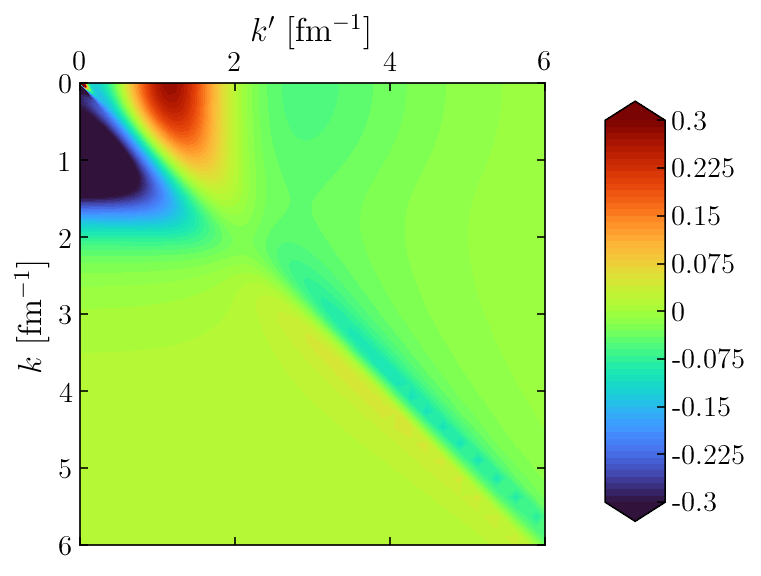

In [33]:
# \delta U(k, k') in 3S1-3S1 channel
plot_contour(k_array, delU_matrix[:ntot,:ntot], colorbar_limits=(-0.3,0.3),
             axes_limits=(0.0,6.0))

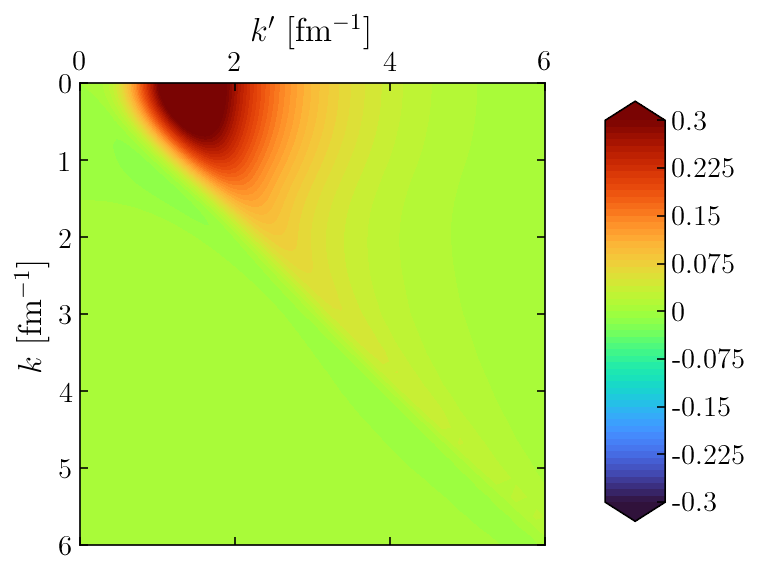

In [34]:
# \delta U(k, k') in 3S1-3D1 channel
plot_contour(k_array, delU_matrix[:ntot,ntot:], colorbar_limits=(-0.3,0.3),
             axes_limits=(0.0,6.0))

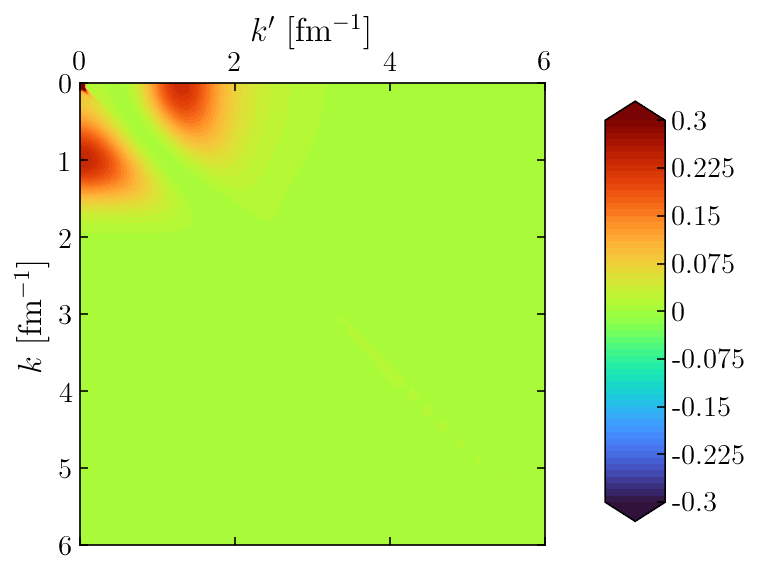

In [35]:
# \delta U^2(k, k')
plot_contour(k_array, delU2_matrix, colorbar_limits=(-0.3,0.3),
             axes_limits=(0.0,6.0))

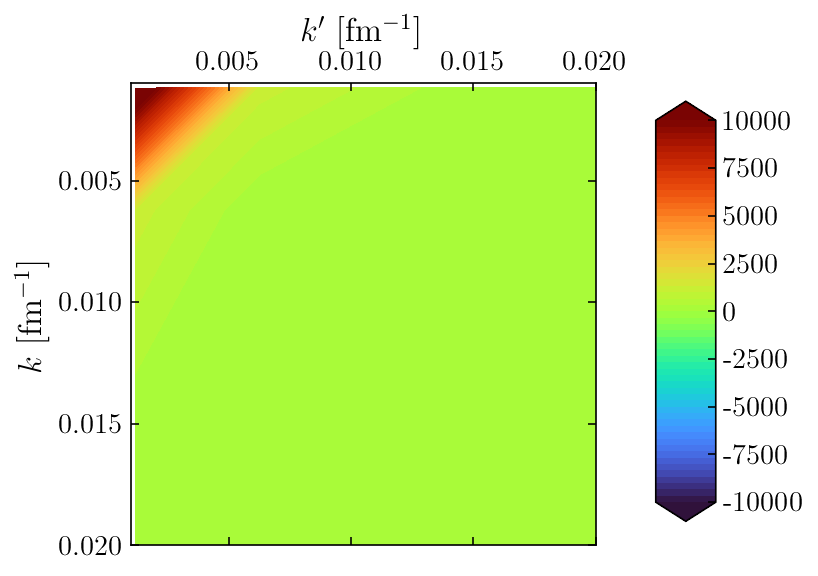

In [36]:
# Zoomed-in version of \delta U^2(k, k')
plot_contour(k_array, delU2_matrix, colorbar_limits=(-1e4,1e4),
             axes_limits=(0.001,0.02))

In [37]:
# 3S1-3S1
print(delU_matrix[:ntot,:ntot].max())
print(delU_matrix[:ntot,:ntot].min())
# 3S1-3D1
print(delU_matrix[:ntot,ntot:].max())
print(delU_matrix[:ntot,ntot:].min())
# \delta U^2
print(delU2_matrix.max())

33.936785380324565
-34.357336481975
0.4094934818961299
-108.93538365656518
11866.962076021728


### Contour plots of $V(k, k')$

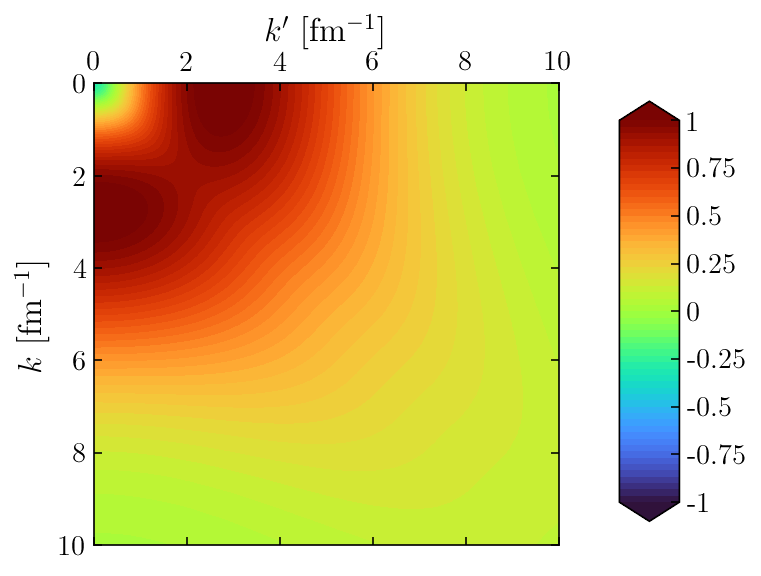

In [38]:
# Plot AV18 in 3S1-3S1 channel
V_matrix = potential.load_potential()
plot_contour(k_array, V_matrix[:ntot,:ntot], colorbar_limits=(-1,1),
             axes_limits=(0.0,10.0))

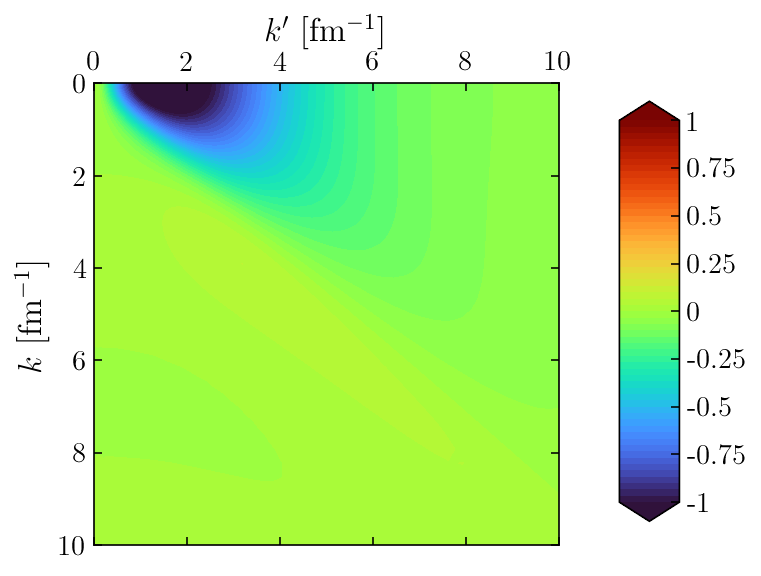

In [39]:
# Plot AV18 in 3S1-3D1 channel
plot_contour(k_array, V_matrix[:ntot,ntot:], colorbar_limits=(-1,1),
             axes_limits=(0.0,10.0))

In [40]:
# # Plot AV18 in 3D1-3D1 block
# plot_contour(k_array, V_matrix[ntot:,ntot:], colorbar_limits=(-1,1),
#              axes_limits=(0.0,15.0))

In [41]:
# # Plot SRG transformation in 3S1-3S1 channel
# U_matrix = unattach_weights_from_matrix(k_array, k_weights, U_matrix_weights,
#                                         coupled_channel=True)
# plot_contour(k_array, U_matrix[:ntot,:ntot], colorbar_limits=(-0.3,0.3),
#              axes_limits=(0.0,6.0))

In [42]:
# # Plot SRG transformation in 3S1-3D1 channel
# plot_contour(k_array, U_matrix[:ntot,ntot:], colorbar_limits=(-0.3,0.3),
#              axes_limits=(0.0,6.0))

## Compare integration over momenta of $\delta U^2(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|)$ between codes

$$
f_{\rm{LDA}}(q) = (4\pi)^2 \int_0^\infty dk k^2 \int_0^\infty dK K^2 \int_{-1}^1 \frac{dx}{2}
\bigl[
    \delta U_{^{3}S_1-^{3}S_1}(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|)
    \delta U^\dagger_{^{3}S_1-^{3}S_1}(|\mathbf{q}-\frac{\mathbf{K}}{2}|, k)
    + \delta U_{^{3}S_1-^{3}D_1}(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|)
    \delta U^\dagger_{^{3}D_1-^{3}S_1}(|\mathbf{q}-\frac{\mathbf{K}}{2}|, k)
\bigr],
$$<br>
where $|\mathbf{q}-\frac{\mathbf{K}}{2}| = \sqrt{q^2+K^2/4-qKx}$.

In [43]:
def lda_function(q_array, K_array, K_weights, potential, channel):
    """Computing f_LDA(q) in the above expression."""
    
    k_array, k_weights = potential.load_mesh()
    x_array, x_weights = leggauss(7)
    k_grid, K_grid, x_grid = np.meshgrid(k_array, K_array, x_array,
                                         indexing='ij')
    dk_grid, dK_grid, dx_grid = np.meshgrid(k_weights, K_weights, x_weights,
                                            indexing='ij')
    
    jacobian_grid = k_grid**2 * dk_grid * K_grid**2 * dK_grid * dx_grid/2
    
    # This gives the entire function (sum of functions) in square brackets
    _, _, deltaU2_func_lda = interpolated_delta_U_lda(potential, channel)
    
    # Loop over q
    f_lda_array = np.zeros_like(q_array)
    for iq, q in enumerate(q_array):
        
        qK_grid = np.sqrt(q**2 + K_grid**2/4 - q*K_grid*x_grid)
        
        deltaU2_grid = deltaU2_func_lda.ev(k_grid, qK_grid)
        
        integrand = (4*np.pi) ** 2 * jacobian_grid * deltaU2_grid
        
        # Integrate over x, K, and k
        f_lda_array[iq] = np.sum(np.sum(np.sum(integrand, axis=-1), axis=-1),
                                 axis=-1)
        
    return f_lda_array

$$
\begin{align}
f_{\rm{vegas}}(q) 
&= \int_0^\infty dk k^2 \int_0^\pi \sin(\theta_k) d\theta_k \int_0^{2\pi} d\phi_k
    \int_0^\infty dK K^2 \int_0^\pi \sin(\theta_K) d\theta_K \int_0^{2\pi} d\phi_K \\
    &\times
    \bigl[
        \delta U_{^{3}S_1-^{3}S_1}(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|)
        \delta U^\dagger_{^{3}S_1-^{3}S_1}(|\mathbf{q}-\frac{\mathbf{K}}{2}|, k)
        + \delta U_{^{3}S_1-^{3}D_1}(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|)
        \delta U^\dagger_{^{3}D_1-^{3}S_1}(|\mathbf{q}-\frac{\mathbf{K}}{2}|, k)
    \bigr],
\end{align}
$$<br>
where $\mathbf{q}=\langle 0,0,q \rangle$, $\mathbf{k}=\langle k \sin(\theta_k) \cos(\phi_k), k \sin(\theta_k) \sin(\phi_k), k \cos(\theta_k) \rangle$, and $\mathbf{K}=\langle K \sin(\theta_K) \cos(\phi_K), K \sin(\theta_K) \sin(\phi_K), K \cos(\theta_K) \rangle$.

In [44]:
def vegas_integrand(
        q, delta_U_functions, delta_U_dagger_functions, delta_U2_functions,
        squared, momenta_array
):
    """Integrand of f_vegas(q) in the above expression."""
    
    # Choose z-axis to be along q_vector
    q_vector = np.array([0, 0, q])

    # Relative momenta k
    k, theta_k, phi_k = momenta_array[:3]
    k_vector = np.array([k * np.sin(theta_k) * np.cos(phi_k),
                         k * np.sin(theta_k) * np.sin(phi_k),
                         k * np.cos(theta_k)])
    
    # C.o.M. momenta K
    K, theta_K, phi_K = momenta_array[3:6]
    K_vector = np.array([K * np.sin(theta_K) * np.cos(phi_K),
                          K * np.sin(theta_K) * np.sin(phi_K),
                          K * np.cos(theta_K)])
    
    # Calculate vector q-K/2
    qK_vector = q_vector - K_vector/2
    qK = la.norm(qK_vector)
    theta_qK = np.arccos(qK_vector[2]/qK)
    phi_qK = np.arctan2(qK_vector[1], qK_vector[0])
        
    # Calculate the Jacobian determinant
    jacobian = k**2 * np.sin(theta_k) * K**2 * np.sin(theta_K)
    
    # This gives the entire function (sum of functions) in square brackets
    if squared:
        deltaU2 = (delta_U2_functions['3S1-3S1'].ev(k, qK)
                   + delta_U2_functions['3S1-3D1'].ev(k, qK))
    else:
        deltaU2 = (
            delta_U_functions['3S1-3S1'].ev(k, qK)
            * delta_U_dagger_functions['3S1-3S1'].ev(qK, k)
            + delta_U_functions['3S1-3D1'].ev(k, qK)
            * delta_U_dagger_functions['3D1-3S1'].ev(qK, k)
        )

    return jacobian * deltaU2

In [45]:
def vegas_function(q_array, potential, channel, squared=False):
    """Computing f_vegas(q) in the above expression."""
    
    delta_U_functions, delta_U_dagger_functions, delta_U2_functions = (
        get_delta_U_functions(potential, channel, order=5)
    )
    
    k_array, _ = potential.load_mesh()
    k_min, k_max = min(k_array), max(k_array)

    # Set-up integration with vegas
    # k_limits = [0, 10]  # Relative momenta up to 15 fm^-1
#     k_limits = [0, 15]  # Relative momenta up to 15 fm^-1
    K_limits = [k_min, 2.7]  # C.o.M. momenta up to 2.7 fm^-1
    k_limits = [k_min, k_max]  # Relative momenta up to 15 fm^-1
    # K_limits = [k_min, 4]  # C.o.M. momenta up to 4 fm^-1
    theta_limits = [0, np.pi]
    phi_limits = [0, 2*np.pi]

    # Set-up integrator with multiple processors
    integ = vegas.Integrator([k_limits, theta_limits, phi_limits,
                              K_limits, theta_limits, phi_limits])

    # Loop over q_vector
    f_vegas_array = np.zeros_like(q_array)
    t0 = time.time()
    for iq, q in enumerate(q_array):
        
        integrand = functools.partial(
            vegas_integrand, q, delta_U_functions, delta_U_dagger_functions,
            delta_U2_functions, squared
        )
        
        # Train the integrator
        integ(integrand, nitn=5, neval=1e3)
        # Final result
        result = integ(integrand, nitn=10, neval=3e3)

        f_vegas_array[iq] = result.mean

    t1 = time.time()
    mins = (t1-t0)/60
    print(f"Done after {mins:.3f} minutes.")
                    
    return f_vegas_array

In [46]:
# Compare angle-averaging vs vegas sampling
K_array, K_weights = gaussian_quadrature_mesh(2.7, 40)
# K_array, K_weights = gaussian_quadrature_mesh(4.0, 40)
q_array, _ = momentum_mesh(8.0, 2.0, 60)

f_lda_array = lda_function(q_array, K_array, K_weights, potential, channel)
# Compute using \delta U and \delta U^\dagger individually
f_vegas_array = vegas_function(q_array, potential, channel)

Done after 0.653 minutes.


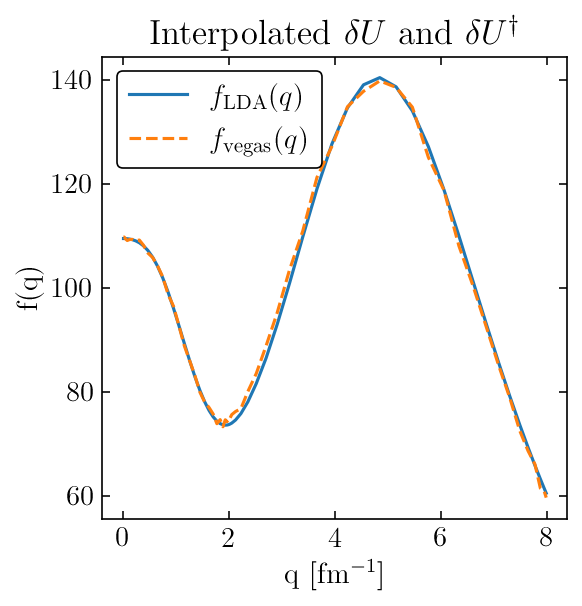

In [47]:
# Plot f_{LDA}(q) and f_{vegas}(q)
plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.plot(q_array, f_lda_array, label=r'$f_{\rm{LDA}}(q)$', linestyle='-')
ax.plot(q_array, f_vegas_array, label=r'$f_{\rm{vegas}}(q)$', linestyle='--')
# ax.set_ylim((50.0, 150.0))
ax.set_xlabel(r'q [fm$^{-1}$]')
ax.set_ylabel('f(q)')
ax.legend(loc='upper left')
ax.set_title(r'Interpolated $\delta U$ and $\delta U^\dagger$')
plt.show()

In [48]:
# # Compute using interpolated \delta U^2
# f_vegas_sq_array = vegas_function(q_array, potential, channel, squared=True)

# # Plot f_{LDA}(q) and f_{vegas}(q)
# plt.close('all')
# f, ax = plt.subplots(figsize=(4, 4))
# ax.plot(q_array, f_lda_array, label=r'$f_{\rm{LDA}}(q)$', linestyle='-')
# ax.plot(q_array, f_vegas_sq_array, label=r'$f_{\rm{vegas}}(q)$', linestyle='--')
# # ax.set_ylim((50.0, 150.0))
# ax.set_xlabel(r'q [fm$^{-1}$]')
# ax.set_ylabel('f(q)')
# ax.legend(loc='upper left')
# ax.set_title(r'Interpolated $\delta U^2$')
# plt.show()

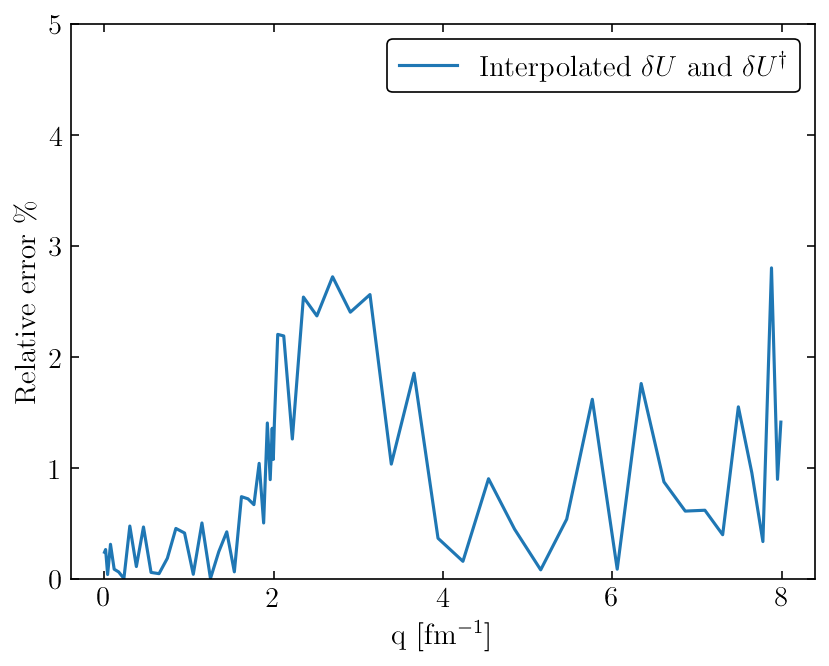

In [49]:
# Plot relative error of f_{LDA}(q) and f_{vegas}(q)
# plt.plot(q_array, abs(f_lda_array-f_vegas_sq_array)/f_lda_array*100,
#          label=r'Interpolated $\delta U^2$')
plt.plot(q_array, abs(f_lda_array-f_vegas_array)/f_lda_array*100,
         label=r'Interpolated $\delta U$ and $\delta U^\dagger$')
plt.xlabel(r'q [fm$^{-1}$]')
plt.ylabel('Relative error \%')
plt.ylim((0,5))
plt.legend()
plt.show()

In [50]:
def gq_function(
        q_array, K_array, K_weights, potential, channel, delta_U_functions,
        delta_U_dagger_functions
):
    """Computing f(q) as in the vegas expression using full Gaussian quadrature
    on the angular integrals as well."""
    
    k_array, k_weights = potential.load_mesh()
    theta_array, theta_weights = gaussian_quadrature_mesh(np.pi, 7)
    phi_array, phi_weights = gaussian_quadrature_mesh(2*np.pi, 13)
    
    k_grid, thetak_grid, phik_grid, K_grid, thetaK_grid, phiK_grid = (
        np.meshgrid(k_array, theta_array, phi_array, K_array, theta_array,
                    phi_array, indexing='ij')
    )
    dk_grid, dthetak_grid, dphik_grid, dK_grid, dthetaK_grid, dphiK_grid = (
        np.meshgrid(k_weights, theta_weights, phi_weights, K_weights,
                    theta_weights, phi_weights, indexing='ij')
    )
    
    jacobian_grid = (
        k_grid**2 * dk_grid * np.sin(thetak_grid) * dthetak_grid * dphik_grid
        * K_grid**2 * dK_grid * np.sin(thetaK_grid) * dthetaK_grid * dphiK_grid
    )
    
    # This gives the entire function (sum of functions) in square brackets
    _, _, deltaU2_func_lda = interpolated_delta_U_lda(potential, channel)
    
    # Loop over q
    t0 = time.time()
    f_gq_array = np.zeros_like(q_array)
    for iq, q in enumerate(q_array):
        
        # Choose z-axis to be along q_vector
        q_vector_grid = q * np.array([
            np.zeros_like(thetak_grid), np.zeros_like(thetak_grid),
            np.ones_like(thetak_grid)
        ])
        K_vector_grid = np.array([
            K_grid * np.sin(thetaK_grid) * np.cos(phiK_grid),
            K_grid * np.sin(thetaK_grid) * np.sin(phiK_grid),
            K_grid * np.cos(thetaK_grid)
        ])
        qK_grid = la.norm(q_vector_grid - K_vector_grid/2, axis=0)

        # Use interpolating function from old LDA code
        deltaU2_grid = deltaU2_func_lda.ev(k_grid, qK_grid)
        
#         # Use interpolating function from new code
#         deltaU2_grid = (
#             delta_U_functions['3S1-3S1'].ev(k_grid, qK_grid)
#             * delta_U_dagger_functions['3S1-3S1'].ev(qK_grid, k_grid)
#             + delta_U_functions['3S1-3D1'].ev(k_grid, qK_grid)
#             * delta_U_dagger_functions['3D1-3S1'].ev(qK_grid, k_grid)
#         )
        
        integrand = jacobian_grid * deltaU2_grid
        
        # Integrate over K_vector and k_vector
        f_gq_array[iq] = np.sum(
            np.sum(
                np.sum(
                    np.sum(
                        np.sum(
                            np.sum(integrand, axis=-1), axis=-1
                        ), axis=-1
                    ), axis=-1
                ), axis=-1
            ), axis=-1
        )
        
    t1 = time.time()
    mins = (t1-t0)/60
    print(f"Done after {mins:.3f} minutes.")
        
    return f_gq_array

In [51]:
# f_gq_function = gq_function(q_array, K_array, K_weights, potential, channel,
#                             delta_U_functions, delta_U_dagger_functions)

In [52]:
# plt.plot(q_array, f_lda_array, label=r'$f_{\rm{LDA}}(q)$', linestyle='-')
# plt.plot(q_array, f_vegas_array, label=r'$f_{\rm{vegas}}(q)$', linestyle='--')
# plt.plot(q_array, f_gq_function, label='Full Gaussian quadrature',
#          linestyle=':')
# plt.ylim((50.0, 150.0))
# plt.xlabel(r'q [fm$^{-1}$]')
# plt.ylabel('f(q)')
# plt.legend(fontsize=11, loc='upper left')
# plt.show()

## Integration over momenta of $\delta U(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|) \delta U^\dagger(|\mathbf{q}-\frac{\mathbf{K}}{2}|,k')$

In [53]:
def vegas_integrand_2():
    return None

In [54]:
def vegas_function_2():
    return None

In [55]:
def gq_function_2():
    return None

Matrix element of $\delta U \delta U^\dagger$ diverges at $k \rightarrow 0$ and $k' \rightarrow 0$. Are the interpolating functions inaccurate because of this? Test by comparing to a full Gaussian quadrature calculation. (Note, the angle-averaging approach is equivalent to integrating over all angles individually. You can choose either approach.)

## Add in the spherical harmonics

_Do these tests in a seperate notebook_

### Try only $L=0$ first

In [56]:
# LDA function with angle-averaging -> f_{LDA}(q)
def lda_function_swaves():
    return None

In [57]:
# vegas sampling function with spherical harmonics -> f_{vegas}(q)
def vegas_function_swaves():
    return None

In [58]:
# Compare angle-averaging vs vegas sampling

# Plot f_{LDA}(q) and f_{vegas}(q)

### Add in $L > 0$ contributions

In [59]:
# LDA function with angle-averaging -> f_{LDA}(q)
def lda_function_full():
    return None

In [60]:
# vegas sampling function with spherical harmonics -> f_{vegas}(q)
def vegas_function_full():
    return None

In [61]:
# Compare angle-averaging vs vegas sampling

# Plot f_{LDA}(q) and f_{vegas}(q)

In [62]:
# If necessary, add in factors and CG's

In [63]:
conda search python

Loading channels: done
# Name                       Version           Build  Channel             
python                        3.8.11      hbdb9e5c_5  pkgs/main           
python                        3.8.13      hbdb9e5c_0  pkgs/main           
python                        3.8.13      hbdb9e5c_1  pkgs/main           
python                        3.8.15      h266c4f5_0  pkgs/main           
python                        3.8.15      hc0d8a6c_2  pkgs/main           
python                        3.8.16      hc0d8a6c_2  pkgs/main           
python                         3.9.6      hc70090a_5  pkgs/main           
python                         3.9.7      hc70090a_1  pkgs/main           
python                        3.9.11      hbdb9e5c_1  pkgs/main           
python                        3.9.11      hbdb9e5c_2  pkgs/main           
python                        3.9.12      hbdb9e5c_0  pkgs/main           
python                        3.9.12      hbdb9e5c_1  pkgs/main           
py